In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# Precinct Shapefile
---
## VEST's Documentation File


Election Results from South Dakota Secretary of State (https://sdsos.gov/elections-voting/election-resources/election-history/2016_Election_History.aspx)
Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release, with the exceptions of Potter County and Yankton County from the 2010 Census VTD release.

Brookings, Brown, Hughes, Hyde, Potter, Sully, and Yankton use countywide vote centers rather than polling locations by precinct. South Dakota counties with vote centers do not record votes by precinct. For these counties, votes were apportioned to precincts based on their share of the countywide number of ballots cast by voters registered with the party of the respective candidates. When this method was tested with counties that report votes by precinct the great majority of precincts were within 4% of the actual candidate vote shares. However, a scattering of precincts deviated by as much as 12% from the actual vote shares. These precincts tend to be in either city centers or outlying areas, which reflects the fact that registered Democrats in rural precincts are more likely to vote for Republican candidates than registered Democrats in urban precincts.

Lawrence County reported absentee votes countywide. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.

The certified precinct report from Minnehaha County adds up to about 18 more votes per office than the countywide totals recorded in the official state canvass. This was evidently an oversight in which the preliminary vote count from Minnehaha County was not updated before the final state canvass.

The following modifications were made in the shapefiles to recreate the 2016 precinct boundaries.

Beadle: Replace 5 commissioner districts with 10 precincts \
Bennett: Merge Martin City wards \
Brown: Adjust 12/16, 21/22; revise Aberdeen city limits to 2016 boundary \
Brule: Merge divisions of 3 \
Butte: Merge 8/13/14 \
Charles Mix: Merge divisions of 3, 6, 11, 12 \
Clark: Replace 5 commissioner districts with 13 precincts \
Codington: 3 county VTDs reorganized into 13 precincts by township list; merge Watertown wards A3/A4, B1/B4/E5, B3/C1, C2/D4, E2/E4; reverse B3 annexation \
Corson: Merge McIntosh/South McIntosh, Lincoln/Oak Creek \
Davison: Merge 4/5, 6/7, 12/13, 17/18 \
Day: Merge divisions of 2, 5, 6; Revise Webster city boundaries \
Dewey: Merge 3/4, 10/11, 12/13 \
Fall River: Merge Edgemont, Oelrichs \
Faulk: Split 6/7 \
Grant: Split 41/45/53, 43/47, 44/49/52/54; Add Milbank wards \
Hand: Merge 1/3, 5/8, 9/10, divisions of 11, 12 \
Hyde: Replace 5 commissioner districts with 3 precincts \
Jackson: Merge divisions of 3, 4 \
Jones: Merge divisions of 1, 3 \
Kingsbury: Replace 5 commissioner districts with 6 precincts \
Lawrence: Merge Whitewood, Rural #1 \
Lincoln: Merge Beresford, Canton 1-3, Canton 4-5, Lennox, Tea \
Mellette: Revise Central/East/West boundaries, White River city limits \
McPherson: Merge Eureka wards with 4/5/6, Leola ward with 1/2 \
Minnehaha: Merge 1-4/1-5, 4-1/5-15, 4-7/4-8, 5-1/5-2; reverse renumbering and changes to corporate boundary since 2016 \
Pennington: Merge CA/SC, HR/LS/RK; Split RH/HC \
Perkins: Merge divisions of 3 \
Potter: Adjust Gettysburg ward boundaries; Merge divisions of 26, 27 \
Roberts: Merge 6/7, 12/14 \
Sully: Revise all precinct boundaries to align with county PDF \
Union: Merge divisions of 2, 6 \
Yankton: Revise Yankton city precincts to align with city limits \
Ziebach: Merge Redelm/N&S Dupree 

* G16PRERTRU - Donald Trump (Republican Party)
* G16PREDCLI - Hillary Clinton (Democratic Party)
* G16PRELJOH - Gary Johnson (Libertarian Party)
* G16PRECCAS - Darrell L. Castle (Constitution Party)


* G16USSRTHU - John R. Thune (Republican Party)
* G16USSDWIL - Jay Williams (Democratic Party)


* G16HALRNOE - Kristi Noem (Republican Party)
* G16HALDHAW - Paula Hawks (Democratic Party)


* G16PUCRNEL - Chris Nelson (Republican Party)
* G16PUCDRED - Henry Red Cloud (Democratic Party)

## Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/sd_2016/sd_2016.shp")

In [3]:
vest_shp.shape

(747, 15)

In [4]:
vest_shp.head(10)

,STATEFP,COUNTYFP,VTDST,NAME,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16USSRTHU,G16USSDWIL,G16HALRNOE,G16HALDHAW,G16PUCRNEL,G16PUCDRED,geometry
0,46,003,0VTD-1,Precinct 1,230,62,11,4,254,60,229,85,270,40,"POLYGON Z ((-98.44574 43.75991 0.00000, -98.44..."
1,46,003,0VTD-2,Precinct 2,120,23,7,3,121,32,107,50,145,10,"POLYGON Z ((-98.67633 43.49910 0.00000, -98.67..."
2,46,003,0VTD-3,Precinct 3,290,101,19,6,314,107,262,159,362,61,"POLYGON Z ((-98.80777 43.93522 0.00000, -98.80..."
3,46,003,0VTD-5,Precinct 5,128,61,11,1,135,62,128,74,153,44,"POLYGON Z ((-98.57036 43.93450 0.00000, -98.57..."
4,46,003,0VTD-7,Precinct 7,206,93,26,5,249,82,203,124,271,53,"POLYGON Z ((-98.49224 43.72048 0.00000, -98.49..."
5,46,007,0VTD-1,Allen,70,183,11,2,112,148,96,166,83,179,"POLYGON Z ((-102.11082 43.38990 0.00000, -102...."
6,46,007,0VTD-4,Vetal-Tuthill,150,7,12,0,157,11,150,16,149,11,"POLYGON Z ((-101.63323 43.34893 0.00000, -101...."
7,46,007,VTD-27,Martin Rural 26/27,235,101,13,4,240,112,244,109,228,118,"POLYGON Z ((-102.09337 43.12966 0.00000, -102...."
8,46,009,0VTD-1,Scotland precinct 1,439,105,29,6,470,114,412,170,496,69,"POLYGON Z ((-97.99104 43.16823 0.00000, -97.99..."
9,46,009,0VTD-2,Avon precinct 2,371,108,16,11,407,105,362,144,425,75,"POLYGON Z ((-98.12346 42.91074 0.00000, -98.12..."


<AxesSubplot:>

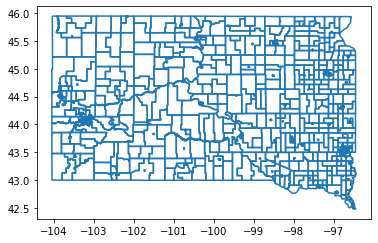

In [5]:
vest_shp.boundary.plot()

## Loading, Combining Election Results
The SOS directed to this link for election results for the 2016 general: https://sdsos.gov/elections-voting/election-resources/election-history/2016_Election_History.aspx

### Presidential Election Results
Presidential candidate Darrell L. Casstle in the VEST file was assumed to indicate Castle in the election results.

In [6]:
pd.set_option('display.max_rows', None)
# Import presidential election results file
pre_16 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - PRE.xlsx")
counties = pre_16.sheet_names

# Create empty list to collect dataframes
df_pre = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(pre_16, sheet_name = county, usecols = [1,2,3,4,5], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_pre.append(df)
# Create the final dataframe    
combined_df_pre = pd.concat(df_pre)
# List county results in alphabetical order for easier merging process later on
combined_df_pre = combined_df_pre.sort_values(by='County')

# Rename the columns to match VEST
combined_df_pre.columns = ['County','Precinct','G16PRERTRU','G16PRELJOH','G16PREDCLI','G16PRECCAS']
# Reorder the columns to match VEST
combined_df_pre = combined_df_pre.reindex(columns=['County','Precinct','G16PRERTRU','G16PREDCLI','G16PRELJOH','G16PRECCAS'])

# Remove the rows with column names and rows with total votes
combined_df_pre = combined_df_pre[combined_df_pre["Precinct"]!="Precinct"]
combined_df_pre = combined_df_pre[combined_df_pre["Precinct"]!="TOTALS"]

# Fill n/a values with 0
combined_df_pre = combined_df_pre.fillna(0)

# Deal with the index
combined_df_pre.reset_index(drop=True,inplace=True)

combined_df_pre.head()

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS
0,Aurora,Precinct-5,128,61,11,1
1,Aurora,Precinct-3,290,101,19,6
2,Aurora,Precinct-2,120,23,7,3
3,Aurora,Precinct-1,230,62,11,4
4,Aurora,Precinct-7,206,93,26,5


### U.S. Senate Election Results

In [7]:
# Import senator election results file
uss_16 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - USS.xlsx")
counties = uss_16.sheet_names

# Create empty list to collect dataframes
df_uss = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(uss_16, sheet_name = county, usecols = [1,2,3], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_uss.append(df)
# Create the final dataframe    
combined_df_uss = pd.concat(df_uss)
# List county results in alphabetical order for easier merging process later on
combined_df_uss = combined_df_uss.sort_values(by='County')

# Rename the columns to match VEST
combined_df_uss.columns = ['County','Precinct','G16USSRTHU','G16USSDWIL']

# Remove the rows with column names and rows with total votes
combined_df_uss = combined_df_uss[combined_df_uss["Precinct"]!="Precinct"]
combined_df_uss = combined_df_uss[combined_df_uss["Precinct"]!="TOTALS"]

# # Drop 'Precinct' column since it is empty
# combined_df_uss = combined_df_uss.drop('Precinct', axis = 1)

# Fill n/a values with 0
combined_df_uss = combined_df_uss.fillna(0)

# Deal with the index
combined_df_uss.reset_index(drop=True,inplace=True)

combined_df_uss.head()

,County,Precinct,G16USSRTHU,G16USSDWIL
0,Aurora,Precinct-5,135,62
1,Aurora,Precinct-3,314,107
2,Aurora,Precinct-2,121,32
3,Aurora,Precinct-1,254,60
4,Aurora,Precinct-7,249,82


### U.S. Representative

In [8]:
# Import representative election results file
hal_16 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - HAL.xlsx")
counties = hal_16.sheet_names

# Create empty list to collect dataframes
df_hal = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(hal_16, sheet_name = county, usecols = [1,2,3], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_hal.append(df)
# Create the final dataframe    
combined_df_hal = pd.concat(df_hal)
# List county results in alphabetical order for easier merging process later on
combined_df_hal = combined_df_hal.sort_values(by='County')

# Rename the columns to match VEST
combined_df_hal.columns = ['County','Precinct','G16HALRNOE','G16HALDHAW']

# Remove the rows with column names and rows with total votes
combined_df_hal = combined_df_hal[combined_df_hal["Precinct"]!="Precinct"]
combined_df_hal = combined_df_hal[combined_df_hal["Precinct"]!="TOTALS"]

# # Drop 'Precinct' column since it is empty
# combined_df_hal = combined_df_hal.drop('Precinct', axis = 1)

# Fill n/a values with 0
combined_df_hal = combined_df_hal.fillna(0)

# Deal with the index
combined_df_hal.reset_index(drop=True,inplace=True)

combined_df_hal.head()

,County,Precinct,G16HALRNOE,G16HALDHAW
0,Aurora,Precinct-5,128,74
1,Aurora,Precinct-3,262,159
2,Aurora,Precinct-2,107,50
3,Aurora,Precinct-1,229,85
4,Aurora,Precinct-7,203,124


### Public Utilities Commissioner Election Results

In [9]:
# Import PUC election results file
puc_16 = pd.ExcelFile("./raw-from-source/Election_Results/SWR Results Precinct - PUC.xlsx")
counties = puc_16.sheet_names

# Create empty list to collect dataframes
df_puc = []

# Iterate over all the sheets within the file
for county in counties:
    # Skip over empty columns and empty rows
    df = pd.read_excel(puc_16, sheet_name = county, usecols = [1,2,3], skiprows=[0,1,2,3,4])
    # Create a county column at the beginning of the dataframe
    df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
    # Add the data to the list
    df_puc.append(df)
# Create the final dataframe    
combined_df_puc = pd.concat(df_puc)
# List county results in alphabetical order for easier merging process later on
combined_df_puc = combined_df_puc.sort_values(by='County')

# Rename the columns to match VEST
combined_df_puc.columns = ['County','Precinct','G16PUCRNEL','G16PUCDRED']

# Remove the rows with column names and rows with total votes
combined_df_puc = combined_df_puc[combined_df_puc["Precinct"]!="Precinct"]
combined_df_puc = combined_df_puc[combined_df_puc["Precinct"]!="TOTALS"]

# # Drop 'Precinct' column since it is empty
# combined_df_puc = combined_df_puc.drop('Precinct', axis = 1)

# Fill n/a values with 0
combined_df_puc = combined_df_puc.fillna(0)

# Deal with the index
combined_df_puc.reset_index(drop=True,inplace=True)

combined_df_puc.head()

,County,Precinct,G16PUCRNEL,G16PUCDRED
0,Aurora,Precinct-5,153,44
1,Aurora,Precinct-3,362,61
2,Aurora,Precinct-2,145,10
3,Aurora,Precinct-1,270,40
4,Aurora,Precinct-7,271,53


### Combine Results

In [10]:
# Concatenate all dataframes
sd_16 = pd.concat([combined_df_pre,combined_df_uss,combined_df_hal,combined_df_puc],axis=1)

# Drop repeated column (County)
sd_16 = sd_16.loc[:,~sd_16.columns.duplicated()]

# # Change strings to integers (County and Precinct columns remain unchanged)
# sd_16 = sd_16.apply(pd.to_numeric, errors='ignore')

sd_16['County'] = sd_16['County'].astype(str)
sd_16['Precinct'] = sd_16['Precinct'].astype(str)

sd_16.head()

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16USSRTHU,G16USSDWIL,G16HALRNOE,G16HALDHAW,G16PUCRNEL,G16PUCDRED
0,Aurora,Precinct-5,128,61,11,1,135,62,128,74,153,44
1,Aurora,Precinct-3,290,101,19,6,314,107,262,159,362,61
2,Aurora,Precinct-2,120,23,7,3,121,32,107,50,145,10
3,Aurora,Precinct-1,230,62,11,4,254,60,229,85,270,40
4,Aurora,Precinct-7,206,93,26,5,249,82,203,124,271,53


### Add in FIPS File

In [11]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="South Dakota"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Make FIPS County Name uppercase
fips_file['County Name']=fips_file['County Name'].str.upper()

#Create the dictionary
sd_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

#Create list of fips codes *
fips_file["unique_ID"] =  "46" + fips_file["FIPS County"]
fips_codes = fips_file["unique_ID"].tolist()

# Modify county names in dataframe to match the FIPs file
# Oglala Lakota county was originally named Shannon county - the county was renamed in 2015
county_name_changes_dict = {"Oglala Lakota":"Shannon"}
sd_16["County"] = sd_16["County"].map(county_name_changes_dict).fillna(sd_16["County"])

# # Use the dictionary to go from a county name to a county FIPS
# sd_16["COUNTYFP"] = sd_16["County"].map(sd_fips_dict).fillna(sd_16["County"])

# # Check the number of counties - looking for 66
# print(len(sd_16["COUNTYFP"].unique()))

In [12]:
sd_fips_dict

{'AURORA': '003',
 'BEADLE': '005',
 'BENNETT': '007',
 'BON HOMME': '009',
 'BROOKINGS': '011',
 'BROWN': '013',
 'BRULE': '015',
 'BUFFALO': '017',
 'BUTTE': '019',
 'CAMPBELL': '021',
 'CHARLES MIX': '023',
 'CLARK': '025',
 'CLAY': '027',
 'CODINGTON': '029',
 'CORSON': '031',
 'CUSTER': '033',
 'DAVISON': '035',
 'DAY': '037',
 'DEUEL': '039',
 'DEWEY': '041',
 'DOUGLAS': '043',
 'EDMUNDS': '045',
 'FALL RIVER': '047',
 'FAULK': '049',
 'GRANT': '051',
 'GREGORY': '053',
 'HAAKON': '055',
 'HAMLIN': '057',
 'HAND': '059',
 'HANSON': '061',
 'HARDING': '063',
 'HUGHES': '065',
 'HUTCHINSON': '067',
 'HYDE': '069',
 'JACKSON': '071',
 'JERAULD': '073',
 'JONES': '075',
 'KINGSBURY': '077',
 'LAKE': '079',
 'LAWRENCE': '081',
 'LINCOLN': '083',
 'LYMAN': '085',
 'MCCOOK': '087',
 'MCPHERSON': '089',
 'MARSHALL': '091',
 'MEADE': '093',
 'MELLETTE': '095',
 'MINER': '097',
 'MINNEHAHA': '099',
 'MOODY': '101',
 'PENNINGTON': '103',
 'PERKINS': '105',
 'POTTER': '107',
 'ROBERTS': '109

In [13]:
sd_16["County"].unique()

array(['Aurora', 'Beadle', 'Bennett', 'Bon Homme', 'Brookings', 'Brown',
       'Brule', 'Buffalo', 'Butte', 'Campbell', 'Charles Mix', 'Clark',
       'Clay', 'Codington', 'Corson', 'Custer', 'Davison', 'Day', 'Deuel',
       'Dewey', 'Douglas', 'Edmunds', 'Fall River', 'Faulk', 'Grant',
       'Gregory', 'Haakon', 'Hamlin', 'Hand', 'Hanson', 'Harding',
       'Hughes', 'Hutchinson', 'Hyde', 'Jackson', 'Jerauld', 'Jones',
       'Kingsbury', 'Lake', 'Lawrence', 'Lincoln', 'Lyman', 'Marshall',
       'McCook', 'McPherson', 'Meade', 'Mellette', 'Miner', 'Minnehaha',
       'Moody', 'Shannon', 'Pennington', 'Perkins', 'Potter', 'Roberts',
       'Sanborn', 'Spink', 'Stanley', 'Sully', 'Todd', 'Tripp', 'Turner',
       'Union', 'Walworth', 'Yankton', 'Ziebach'], dtype=object)

In [14]:
county_dict = {'Aurora':'AURORA', 'Beadle':'BEADLE', 'Bennett':'BENNETT', 'Bon Homme':'BON HOMME', 'Brookings':'BROOKINGS', 'Brown':'BROWN',
       'Brule':'BRULE', 'Buffalo':'BUFFALO', 'Butte':'BUTTE', 'Campbell':'CAMPBELL', 'Charles Mix':'CHARLES MIX', 'Clark':'CLARK',
       'Clay':'CLAY', 'Codington':'CODINGTON', 'Corson':'CORSON', 'Custer':'CUSTER', 'Davison':'DAVISON', 'Day':'DAY', 'Deuel':'DEUEL',
       'Dewey':'DEWEY', 'Douglas':'DOUGLAS', 'Edmunds':'EDMUNDS', 'Fall River':'FALL RIVER', 'Faulk':'FAULK', 'Grant':'GRANT',
       'Gregory':'GREGORY', 'Haakon':'HAAKON', 'Hamlin':'HAMLIN', 'Hand':'HAND', 'Hanson':'HANSON', 'Harding':'HARDING',
       'Hughes':'HUGHES', 'Hutchinson':'HUTCHINSON', 'Hyde':'HYDE', 'Jackson':'JACKSON', 'Jerauld':'JERAULD', 'Jones':'JONES',
       'Kingsbury':'KINGSBURY', 'Lake':'LAKE', 'Lawrence':'LAWRENCE', 'Lincoln':'LINCOLN', 'Lyman':'LYMAN', 'Marshall':'MARSHALL',
       'McCook':'MCCOOK', 'McPherson':'MCPHERSON', 'Meade':'MEADE', 'Mellette':'MELLETTE', 'Miner':'MINER', 'Minnehaha':'MINNEHAHA',
       'Moody':'MOODY', 'Shannon':'SHANNON', 'Pennington':'PENNINGTON', 'Perkins':'PERKINS', 'Potter':'POTTER', 'Roberts':'ROBERTS',
       'Sanborn':'SANBORN', 'Spink':'SPINK', 'Stanley':'STANLEY', 'Sully':'SULLY', 'Todd':'TODD', 'Tripp':'TRIPP', 'Turner':'TURNER',
       'Union':'UNION', 'Walworth':'WALWORTH', 'Yankton':'YANKTON', 'Ziebach':'ZIEBACH'
}

In [15]:
#Use the dictionary to change the names
sd_16["County"]=sd_16["County"].map(county_dict).fillna(sd_16["County"])

In [16]:
#Map to the correct FIP
sd_16["COUNTYFP"]=sd_16["County"].map(sd_fips_dict).fillna(sd_16["County"])

#Print out the FIPS to make sure they all are in the correct format
sd_16["County"].unique()

array(['AURORA', 'BEADLE', 'BENNETT', 'BON HOMME', 'BROOKINGS', 'BROWN',
       'BRULE', 'BUFFALO', 'BUTTE', 'CAMPBELL', 'CHARLES MIX', 'CLARK',
       'CLAY', 'CODINGTON', 'CORSON', 'CUSTER', 'DAVISON', 'DAY', 'DEUEL',
       'DEWEY', 'DOUGLAS', 'EDMUNDS', 'FALL RIVER', 'FAULK', 'GRANT',
       'GREGORY', 'HAAKON', 'HAMLIN', 'HAND', 'HANSON', 'HARDING',
       'HUGHES', 'HUTCHINSON', 'HYDE', 'JACKSON', 'JERAULD', 'JONES',
       'KINGSBURY', 'LAKE', 'LAWRENCE', 'LINCOLN', 'LYMAN', 'MARSHALL',
       'MCCOOK', 'MCPHERSON', 'MEADE', 'MELLETTE', 'MINER', 'MINNEHAHA',
       'MOODY', 'SHANNON', 'PENNINGTON', 'PERKINS', 'POTTER', 'ROBERTS',
       'SANBORN', 'SPINK', 'STANLEY', 'SULLY', 'TODD', 'TRIPP', 'TURNER',
       'UNION', 'WALWORTH', 'YANKTON', 'ZIEBACH'], dtype=object)

In [17]:
sd_16.head(1)

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16USSRTHU,G16USSDWIL,G16HALRNOE,G16HALDHAW,G16PUCRNEL,G16PUCDRED,COUNTYFP
0,AURORA,Precinct-5,128,61,11,1,135,62,128,74,153,44,003


In [18]:
inv_sd_fips_dict = {v: k for k, v in sd_fips_dict.items()}
vest_shp["County_Name"]=vest_shp["COUNTYFP"].map(inv_sd_fips_dict).fillna(vest_shp["COUNTYFP"])
vest_shp

,STATEFP,COUNTYFP,VTDST,NAME,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16USSRTHU,G16USSDWIL,G16HALRNOE,G16HALDHAW,G16PUCRNEL,G16PUCDRED,geometry,County_Name
0,46,003,0VTD-1,Precinct 1,230,62,11,4,254,60,229,85,270,40,"POLYGON Z ((-98.44574 43.75991 0.00000, -98.44...",AURORA
1,46,003,0VTD-2,Precinct 2,120,23,7,3,121,32,107,50,145,10,"POLYGON Z ((-98.67633 43.49910 0.00000, -98.67...",AURORA
2,46,003,0VTD-3,Precinct 3,290,101,19,6,314,107,262,159,362,61,"POLYGON Z ((-98.80777 43.93522 0.00000, -98.80...",AURORA
3,46,003,0VTD-5,Precinct 5,128,61,11,1,135,62,128,74,153,44,"POLYGON Z ((-98.57036 43.93450 0.00000, -98.57...",AURORA
4,46,003,0VTD-7,Precinct 7,206,93,26,5,249,82,203,124,271,53,"POLYGON Z ((-98.49224 43.72048 0.00000, -98.49...",AURORA
5,46,007,0VTD-1,Allen,70,183,11,2,112,148,96,166,83,179,"POLYGON Z ((-102.11082 43.38990 0.00000, -102....",BENNETT
6,46,007,0VTD-4,Vetal-Tuthill,150,7,12,0,157,11,150,16,149,11,"POLYGON Z ((-101.63323 43.34893 0.00000, -101....",BENNETT
7,46,007,VTD-27,Martin Rural 26/27,235,101,13,4,240,112,244,109,228,118,"POLYGON Z ((-102.09337 43.12966 0.00000, -102....",BENNETT
8,46,009,0VTD-1,Scotland precinct 1,439,105,29,6,470,114,412,170,496,69,"POLYGON Z ((-97.99104 43.16823 0.00000, -97.99...",BON HOMME
9,46,009,0VTD-2,Avon precinct 2,371,108,16,11,407,105,362,144,425,75,"POLYGON Z ((-98.12346 42.91074 0.00000, -98.12...",BON HOMME


### Compare Vote Totals Before Allocation

In [19]:
races = [x for x in vest_shp.columns if 'G16' in x]
races

['G16PRERTRU',
 'G16PREDCLI',
 'G16PRELJOH',
 'G16PRECCAS',
 'G16USSRTHU',
 'G16USSDWIL',
 'G16HALRNOE',
 'G16HALDHAW',
 'G16PUCRNEL',
 'G16PUCDRED']

In [20]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(sd_16[i])
print(sum_var_1)
print(sum_var_2)

1466599
1466367


## Assign and Reallocate Absentee Votes
Absentee votes reported for Brookings, Brown, Hughes, Lawrence, Potter, Sully, Yankton counties

In [22]:
data_columns = ['G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH', 'G16PRECCAS',
       'G16USSRTHU', 'G16USSDWIL', 'G16HALRNOE', 'G16HALDHAW', 'G16PUCRNEL',
       'G16PUCDRED']

In [23]:
def assign_absentee(filtered_election):
    to_dole_out = filtered_election[filtered_election['Precinct']=='Absentee Precinct']
    to_dole_out_totals = to_dole_out
    filtered_election = filtered_election[filtered_election.Precinct != 'Absentee Precinct']
    #Create a df with the county-by-county sums of precinct-level votes, this will be used in the allocation, clean the index
    precinct_specific_totals = pd.DataFrame(filtered_election.groupby(["County"]).sum())
    precinct_specific_totals.reset_index(inplace=True,drop=False)
    filtered_election.reset_index(inplace=True,drop=True)
    
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        filtered_election.loc[:,add_var]=0.0
        filtered_election.loc[:,rem_var]=0.0
        filtered_election.loc[:,floor_var]=0.0
    
    for index, row in filtered_election.iterrows():
        #No countywide votes for 510
        if row["County"] in to_dole_out['County'].unique():
            for race in races:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the county
                county_id = row["County"]
                #Get the denominator for the allocation (the precinct vote totals)
                denom = precinct_specific_totals.loc[precinct_specific_totals["County"]==county_id][race]
                #Get one of the numerators, how many countywide votes to allocate
                numer = to_dole_out_totals.loc[to_dole_out_totals["County"]==county_id][race]

                #Get the vote totals for this race in this precinct
                val = filtered_election.loc[index,race]

                #Get the vote share, the precincts % of total precinct votes in the county times votes to allocate
                if float(denom) !=0:
                    vote_share = (float(val)/float(denom))*float(numer)
                else:
                    vote_share = 0


                filtered_election.loc[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                filtered_election.loc[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                filtered_election.loc[index,floor_var] = np.floor(vote_share)
                
    #After the first pass through, get the sums of the races by county            
    first_allocation = pd.DataFrame(filtered_election.groupby(["County"]).sum())

    #Now we want to iterate county by county to work on rounding
    county_list = list(to_dole_out_totals["County"].unique()) 

    #Iterate over the counties
    for county in county_list:
        for race in races:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["County"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in filtered_election.loc[filtered_election["County"]==county][rem_var].nlargest(to_go).index:
                filtered_election.loc[index,add_var] = np.ceil(filtered_election.loc[index,add_var])

    #Iterate over every race again
    for race in races:
        add_var = race+"_add"
        #Round every allocation down
        filtered_election.loc[:,add_var]=np.floor(filtered_election.loc[:,add_var])
        #Add every allocation to the total
        filtered_election.loc[:,race]+=filtered_election.loc[:,add_var]


    #Filter back down to the original columns
    filtered_election = filtered_election[list(sd_16.columns)]
    return filtered_election

#### Brookings

In [24]:
# Brookings
brookings_dict = {'County':['BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS','BROOKINGS'],
                 'Precinct':['1-1 Brookings Activity Center','Absentee Precinct','1-11 Holy Life Tabernacle','1-3 Swiftel Center','1-5 Elkton Community Center','1-6 McKnight Hall','1-2 Bethel Baptist Church','1-10 Volga Community Center','1-9 Sinai American Legion','1-8 Trinity Lutheran Church','1-4 Aurora Little Hall','1-7 Bruce City Hall'],
                 'COUNTYFP':['011','011','011','011','011','011','011','011','011','011','011','011'],
                 'G16PRERTRU':[646,2183,490,378,267,361,1068,565,140,83,324,243],
                 'G16PREDCLI':[724,2122,319,240,74,111,753,230,38,48,144,76],
                 'G16PRELJOH':[161,255,69,72,17,26,143,66,10,4,37,21],
                 'G16PRECCAS':[27,59,13,5,6,3,31,9,3,1,9,6],
                 'G16USSRTHU':[944,2937,648,527,296,400,1442,708,161,104,373,277],
                 'G16USSDWIL':[621,1697,250,175,68,109,582,159,34,37,137,78],
                 'G16HALRNOE':[778,2444,546,437,262,360,1208,598,136,94,309,246],
                 'G16HALDHAW':[780,2199,354,269,100,147,803,281,59,46,203,111],
                 'G16PUCRNEL':[911,3048,649,488,315,408,1433,700,165,109,387,286],
                 'G16PUCDRED':[566,1450,215,172,41,80,492,136,25,26,109,64]}
brookings_df = pd.DataFrame(brookings_dict)
brookings_df = assign_absentee(brookings_df)
brookings_df

C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16USSRTHU,G16USSDWIL,G16HALRNOE,G16HALDHAW,G16PUCRNEL,G16PUCDRED,COUNTYFP
0,BROOKINGS,1-1 Brookings Activity Center,955.0,1281.0,227.0,41.0,1416.0,1089.0,1160.0,1324.0,1386.0,992.0,011
1,BROOKINGS,1-11 Holy Life Tabernacle,724.0,565.0,97.0,20.0,972.0,439.0,814.0,601.0,987.0,377.0,011
2,BROOKINGS,1-3 Swiftel Center,559.0,425.0,101.0,8.0,790.0,307.0,652.0,457.0,742.0,302.0,011
3,BROOKINGS,1-5 Elkton Community Center,395.0,131.0,24.0,9.0,444.0,119.0,391.0,170.0,479.0,72.0,011
4,BROOKINGS,1-6 McKnight Hall,533.0,196.0,37.0,5.0,600.0,191.0,537.0,249.0,620.0,140.0,011
5,BROOKINGS,1-2 Bethel Baptist Church,1579.0,1333.0,201.0,47.0,2162.0,1021.0,1801.0,1363.0,2179.0,862.0,011
6,BROOKINGS,1-10 Volga Community Center,835.0,407.0,93.0,14.0,1062.0,279.0,892.0,477.0,1065.0,238.0,011
7,BROOKINGS,1-9 Sinai American Legion,207.0,67.0,14.0,4.0,241.0,60.0,203.0,100.0,251.0,44.0,011
8,BROOKINGS,1-8 Trinity Lutheran Church,123.0,85.0,6.0,1.0,156.0,65.0,140.0,78.0,166.0,46.0,011
9,BROOKINGS,1-4 Aurora Little Hall,479.0,255.0,52.0,14.0,559.0,240.0,461.0,345.0,589.0,191.0,011


#### Brown

In [25]:
# Brown
brown_dict = {'County':['BROWN','BROWN','BROWN','BROWN','BROWN','BROWN','BROWN','BROWN','BROWN','BROWN','BROWN','BROWN'],
                 'Precinct':['Best Western Ramkota Hotel and Convention Center','AmericInn Event Center','Frederick Community Center','Hecla Community Center','Claremont Fire Station','Groton Community Center','Stratford Communty Center','Warner Community Center','Westport Community Center','Columbia American Legion','Absentee Precinct','Courthouse Community Room'],
                 'COUNTYFP':['013','013','013','013','013','013','013','013','013','013','013','013'],
                 'G16PRERTRU':[1707,1554,169,142,92,528,98,298,158,181,3338,1348],
                 'G16PREDCLI':[766,753,78,77,61,230,58,166,59,72,2337,795],
                 'G16PRELJOH':[157,183,11,7,3,40,17,18,6,8,274,191],
                 'G16PRECCAS':[19,14,0,0,2,5,3,5,1,2,59,23],
                 'G16USSRTHU':[2019,1846,195,161,108,619,116,348,150,201,3949,1659],
                 'G16USSDWIL':[651,653,64,75,51,192,61,145,70,61,2063,707],
                 'G16HALRNOE':[1746,1576,160,127,84,499,97,293,128,164,3413,1389],
                 'G16HALDHAW':[929,926,99,109,74,310,82,202,91,101,2616,953],
                 'G16PUCRNEL':[2072,1898,193,160,116,655,124,388,162,204,4163,1640],
                 'G16PUCDRED':[507,524,56,58,35,120,44,88,55,55,1651,636]}
brown_df = pd.DataFrame(brown_dict)
brown_df = assign_absentee(brown_df)
brown_df

C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16USSRTHU,G16USSDWIL,G16HALRNOE,G16HALDHAW,G16PUCRNEL,G16PUCDRED,COUNTYFP
0,BROWN,Best Western Ramkota Hotel and Convention Center,2615.0,1341.0,224.0,34.0,3093.0,1143.0,2697.0,1556.0,3205.0,891.0,013
1,BROWN,AmericInn Event Center,2381.0,1318.0,261.0,25.0,2828.0,1146.0,2435.0,1551.0,2936.0,921.0,013
2,BROWN,Frederick Community Center,259.0,136.0,16.0,0.0,299.0,112.0,247.0,166.0,299.0,98.0,013
3,BROWN,Hecla Community Center,218.0,135.0,10.0,0.0,247.0,132.0,196.0,183.0,247.0,102.0,013
4,BROWN,Claremont Fire Station,141.0,107.0,4.0,4.0,165.0,90.0,130.0,124.0,179.0,62.0,013
5,BROWN,Groton Community Center,809.0,403.0,57.0,9.0,948.0,337.0,771.0,519.0,1013.0,211.0,013
6,BROWN,Stratford Communty Center,150.0,101.0,24.0,5.0,178.0,107.0,150.0,137.0,192.0,77.0,013
7,BROWN,Warner Community Center,456.0,291.0,26.0,9.0,533.0,255.0,453.0,338.0,600.0,155.0,013
8,BROWN,Westport Community Center,242.0,103.0,9.0,2.0,230.0,123.0,198.0,153.0,251.0,97.0,013
9,BROWN,Columbia American Legion,277.0,126.0,11.0,4.0,308.0,107.0,253.0,169.0,316.0,97.0,013


#### Hughes

In [27]:
# Hughes
hughes_dict = {'County':['HUGHES','HUGHES','HUGHES','HUGHES','HUGHES','HUGHES','HUGHES','HUGHES'],
                 'Precinct':['Absentee Precinct','Lutheran Memorial Church','Faith Lutheran Church','PILC Rec Center','Hyde Residence','Harrold City Auditorium','Blunt City Hall','New Life Assembly of God Church'],
                 'COUNTYFP':['065','065','065','065','065','065','065','065'],
                 'G16PRERTRU':[1140,788,1164,463,48,92,151,1328],
                 'G16PREDCLI':[706,451,526,250,32,9,30,445],
                 'G16PRELJOH':[91,108,108,42,5,2,9,115],
                 'G16PRECCAS':[7,14,17,6,0,3,2,21],
                 'G16USSRTHU':[1398,1048,1473,540,53,95,149,1582],
                 'G16USSDWIL':[557,322,362,229,30,13,45,332],
                 'G16HALRNOE':[1242,890,1290,466,44,93,143,1427],
                 'G16HALDHAW':[724,489,546,300,38,16,52,504],
                 'G16PUCRNEL':[1532,1126,1565,582,50,94,161,1639],
                 'G16PUCDRED':[406,233,261,176,31,15,33,260]}
hughes_df = pd.DataFrame(hughes_dict)
hughes_df = assign_absentee(hughes_df)
hughes_df

C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16USSRTHU,G16USSDWIL,G16HALRNOE,G16HALDHAW,G16PUCRNEL,G16PUCDRED,COUNTYFP
0,HUGHES,Lutheran Memorial Church,1011.0,634.0,133.0,16.0,1344.0,457.0,1144.0,671.0,1457.0,327.0,065
1,HUGHES,Faith Lutheran Church,1493.0,739.0,133.0,19.0,1890.0,513.0,1658.0,749.0,2024.0,366.0,065
2,HUGHES,PILC Rec Center,594.0,351.0,52.0,7.0,693.0,325.0,599.0,412.0,753.0,247.0,065
3,HUGHES,Hyde Residence,61.0,45.0,6.0,0.0,68.0,42.0,57.0,52.0,65.0,43.0,065
4,HUGHES,Harrold City Auditorium,118.0,13.0,3.0,3.0,122.0,18.0,119.0,22.0,122.0,21.0,065
5,HUGHES,Blunt City Hall,194.0,42.0,11.0,2.0,191.0,64.0,184.0,71.0,208.0,46.0,065
6,HUGHES,New Life Assembly of God Church,1703.0,625.0,142.0,23.0,2030.0,471.0,1834.0,692.0,2120.0,365.0,065


#### Lawrence

In [28]:
# lawrence
lawrence_dict = {'County':['LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE','LAWRENCE'],
                 'Precinct':['Precinct-03','Precinct-04','Precinct-02','Precinct-05','Precinct-06','Precinct-01','Precinct-08','Precinct-09','Precinct-10','Absentee Precinct','Precinct-07'],
                 'COUNTYFP':['081','081','081','081','081','081','081','081','081','081','081'],
                 'G16PRERTRU':[698,455,611,166,134,468,116,467,1015,2969,312],
                 'G16PREDCLI':[327,237,259,122,52,264,26,100,268,1585,116],
                 'G16PRELJOH':[103,87,109,28,14,107,11,53,96,281,45],
                 'G16PRECCAS':[13,10,20,1,3,18,3,6,22,41,4],
                 'G16USSRTHU':[858,554,731,201,149,610,123,497,1135,3330,378],
                 'G16USSDWIL':[284,239,269,113,56,247,30,131,264,1531,103],
                 'G16HALRNOE':[817,502,696,180,144,570,120,469,1071,3120,352],
                 'G16HALDHAW':[325,288,300,134,60,281,32,160,317,1747,130],
                 'G16PUCRNEL':[851,543,704,196,134,588,126,482,1115,3402,370],
                 'G16PUCDRED':[258,218,255,117,66,239,30,130,260,1316,100]}
lawrence_df = pd.DataFrame(lawrence_dict)
lawrence_df = assign_absentee(lawrence_df)
lawrence_df

C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16USSRTHU,G16USSDWIL,G16HALRNOE,G16HALDHAW,G16PUCRNEL,G16PUCDRED,COUNTYFP
0,LAWRENCE,Precinct-03,1165.0,620.0,147.0,18.0,1404.0,534.0,1335.0,605.0,1418.0,461.0,081
1,LAWRENCE,Precinct-04,759.0,449.0,125.0,14.0,906.0,450.0,820.0,536.0,905.0,389.0,081
2,LAWRENCE,Precinct-02,1019.0,491.0,156.0,28.0,1196.0,506.0,1137.0,559.0,1173.0,456.0,081
3,LAWRENCE,Precinct-05,277.0,231.0,40.0,2.0,329.0,213.0,294.0,249.0,326.0,209.0,081
4,LAWRENCE,Precinct-06,224.0,99.0,20.0,4.0,244.0,105.0,235.0,112.0,223.0,118.0,081
5,LAWRENCE,Precinct-01,781.0,500.0,153.0,25.0,998.0,465.0,932.0,523.0,980.0,427.0,081
6,LAWRENCE,Precinct-08,193.0,49.0,16.0,4.0,201.0,56.0,196.0,60.0,210.0,54.0,081
7,LAWRENCE,Precinct-09,779.0,189.0,76.0,9.0,813.0,247.0,767.0,298.0,803.0,232.0,081
8,LAWRENCE,Precinct-10,1693.0,508.0,137.0,31.0,1857.0,497.0,1750.0,590.0,1857.0,464.0,081
9,LAWRENCE,Precinct-07,521.0,220.0,64.0,6.0,618.0,194.0,575.0,242.0,616.0,179.0,081


#### Potter

In [29]:
# Potter
potter_dict = {'County':['POTTER','POTTER','POTTER'],
                 'Precinct':['Gettysburg Legion Annex','Hoven American Legion','Absentee Precinct'],
                 'COUNTYFP':['107','107','107'],
                 'G16PRERTRU':[599,269,201],
                 'G16PREDCLI':[117,37,61],
                 'G16PRELJOH':[22,5,13],
                 'G16PRECCAS':[3,4,4],
                 'G16USSRTHU':[597,279,211],
                 'G16USSDWIL':[142,42,69],
                 'G16HALRNOE':[592,270,212],
                 'G16HALDHAW':[156,48,64],
                 'G16PUCRNEL':[647,298,219],
                 'G16PUCDRED':[79,15,45]}
potter_df = pd.DataFrame(potter_dict)
potter_df = assign_absentee(potter_df)
potter_df

C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16USSRTHU,G16USSDWIL,G16HALRNOE,G16HALDHAW,G16PUCRNEL,G16PUCDRED,COUNTYFP
0,POTTER,Gettysburg Legion Annex,738.0,163.0,33.0,5.0,741.0,195.0,738.0,205.0,797.0,117.0,107
1,POTTER,Hoven American Legion,331.0,52.0,7.0,6.0,346.0,58.0,336.0,63.0,367.0,22.0,107


#### Sully

In [30]:
# Sully
sully_dict = {'County':['SULLY','SULLY','SULLY','SULLY'],
                 'Precinct':['Absentee Precinct','Bill Floyd Shop','Phoenix Center','Agar Fire Hall'],
                 'COUNTYFP':['119','119','119','119'],
                 'G16PRERTRU':[123,91,390,75],
                 'G16PREDCLI':[42,16,63,16],
                 'G16PRELJOH':[9,4,25,2],
                 'G16PRECCAS':[2,0,3,0],
                 'G16USSRTHU':[138,90,417,73],
                 'G16USSDWIL':[36,13,67,20],
                 'G16HALRNOE':[129,88,382,69],
                 'G16HALDHAW':[45,22,100,24],
                 'G16PUCRNEL':[145,96,413,80],
                 'G16PUCDRED':[26,12,58,11]}
sully_df = pd.DataFrame(sully_dict)
sully_df = assign_absentee(sully_df)
sully_df

C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16USSRTHU,G16USSDWIL,G16HALRNOE,G16HALDHAW,G16PUCRNEL,G16PUCDRED,COUNTYFP
0,SULLY,Bill Floyd Shop,111.0,23.0,5.0,0.0,112.0,18.0,109.0,29.0,119.0,16.0,119
1,SULLY,Phoenix Center,476.0,91.0,32.0,5.0,516.0,91.0,473.0,131.0,515.0,77.0,119
2,SULLY,Agar Fire Hall,92.0,23.0,3.0,0.0,90.0,27.0,86.0,31.0,100.0,14.0,119


#### Yankton

In [31]:
# Yankton
yankton_dict = {'County':['YANKTON','YANKTON','YANKTON','YANKTON','YANKTON','YANKTON','YANKTON','YANKTON'],
                 'Precinct':['Gayville Community Center','Lesterville Fire Hall','National Field Archery Assoc.','Mayfield Store','Yankton City Hall','Lewis and Clark Rec Area','Absentee Precinct',"JoDean's Steakhouse and Lounge"],
                 'COUNTYFP':['135','135','135','135','135','135','135','135'],
                 'G16PRERTRU':[228,207,1063,196,841,312,2327,480],
                 'G16PREDCLI':[126,43,488,73,525,93,1743,210],
                 'G16PRELJOH':[38,12,96,10,136,14,183,62],
                 'G16PRECCAS':[6,1,26,4,20,5,40,8],
                 'G16USSRTHU':[275,216,1248,189,998,338,2729,543],
                 'G16USSDWIL':[127,46,424,94,530,87,1565,215],
                 'G16HALRNOE':[228,186,1098,175,868,305,2399,499],
                 'G16HALDHAW':[169,75,573,113,644,115,1885,254],
                 'G16PUCRNEL':[293,217,1288,212,1023,358,2963,595],
                 'G16PUCDRED':[86,36,312,60,429,53,1174,136]}
yankton_df = pd.DataFrame(yankton_dict)
yankton_df = assign_absentee(yankton_df)
yankton_df

C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16USSRTHU,G16USSDWIL,G16HALRNOE,G16HALDHAW,G16PUCRNEL,G16PUCDRED,COUNTYFP
0,YANKTON,Gayville Community Center,387.0,267.0,57.0,9.0,472.0,257.0,391.0,333.0,511.0,177.0,135
1,YANKTON,Lesterville Fire Hall,352.0,91.0,18.0,2.0,371.0,93.0,319.0,148.0,378.0,74.0,135
2,YANKTON,National Field Archery Assoc.,1807.0,1034.0,144.0,41.0,2143.0,860.0,1882.0,1129.0,2245.0,641.0,135
3,YANKTON,Mayfield Store,333.0,155.0,15.0,6.0,325.0,191.0,300.0,223.0,370.0,123.0,135
4,YANKTON,Yankton City Hall,1429.0,1112.0,203.0,31.0,1713.0,1075.0,1488.0,1269.0,1784.0,882.0,135
5,YANKTON,Lewis and Clark Rec Area,530.0,197.0,21.0,8.0,580.0,176.0,523.0,226.0,624.0,109.0,135
6,YANKTON,JoDean's Steakhouse and Lounge,816.0,445.0,93.0,13.0,932.0,436.0,855.0,500.0,1037.0,280.0,135


In [32]:
counties = ['BROOKINGS','BROWN','HUGHES','LAWRENCE','POTTER','SULLY','YANKTON']

In [33]:
pd.set_option('display.max_rows', 20)
print(sd_16[sd_16['County'].isin(counties)])
pd.set_option('display.max_rows', 10)

        County                        Precinct  G16PRERTRU  G16PREDCLI  \
24   BROOKINGS   1-1 Brookings Activity Center         646         724   
25   BROOKINGS               Absentee Precinct        2183        2122   
26   BROOKINGS       1-11 Holy Life Tabernacle         490         319   
27   BROOKINGS              1-3 Swiftel Center         378         240   
28   BROOKINGS     1-5 Elkton Community Center         267          74   
..         ...                             ...         ...         ...   
696    YANKTON                  Mayfield Store         196          73   
697    YANKTON               Yankton City Hall         841         525   
698    YANKTON        Lewis and Clark Rec Area         312          93   
699    YANKTON               Absentee Precinct        2327        1743   
700    YANKTON  JoDean's Steakhouse and Lounge         480         210   

     G16PRELJOH  G16PRECCAS  G16USSRTHU  G16USSDWIL  G16HALRNOE  G16HALDHAW  \
24          161          27     

In [34]:
sd_16 = sd_16[~sd_16['County'].isin(counties)]
sd_16 = pd.concat([sd_16, brookings_df,brown_df,hughes_df,lawrence_df,potter_df,sully_df,yankton_df], ignore_index = True)

In [35]:
# Check vote totals again to make sure all the votes are in
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(sd_16[i])
print(sum_var_1)
print(sum_var_2)

1466599
1466367.0


In [36]:
data = [['ABSENTEE','Absentee','000',30,24,5,5,33,22,31,27,32,23]]
 
# Create dataframe of absentee votes
to_dole_out_totals = pd.DataFrame(data, columns = ["County","Precinct","COUNTYFP",'G16PRERTRU',
 'G16PREDCLI',
 'G16PRELJOH',
 'G16PRECCAS',
 'G16USSRTHU',
 'G16USSDWIL',
 'G16HALRNOE',
 'G16HALDHAW',
 'G16PUCRNEL',
 'G16PUCDRED'])

In [37]:
df_with_absentee_reallocated = sd_16.copy()

In [38]:
totals = pd.DataFrame(df_with_absentee_reallocated.sum())
precinct_vote_total_across_districts = totals.T

In [39]:
precinct_vote_total_across_districts

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16USSRTHU,G16USSDWIL,G16HALRNOE,G16HALDHAW,G16PUCRNEL,G16PUCDRED,COUNTYFP
0,AURORAAURORAAURORAAURORAAURORABEADLEBEADLEBEAD...,Precinct-5Precinct-3Precinct-2Precinct-1Precin...,227701.0,117442.0,20845.0,4059.0,265494.0,104125.0,237141.0,132792.0,268927.0,87841.0,0030030030030030050050050050050050050050050050...


In [40]:
to_dole_out_totals

,County,Precinct,COUNTYFP,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16USSRTHU,G16USSDWIL,G16HALRNOE,G16HALDHAW,G16PUCRNEL,G16PUCDRED
0,ABSENTEE,Absentee,000,30,24,5,5,33,22,31,27,32,23


In [41]:
races=['G16PRERTRU',
 'G16PREDCLI',
 'G16PRELJOH',
 'G16PRECCAS',
 'G16USSRTHU',
 'G16USSDWIL',
 'G16HALRNOE',
 'G16HALDHAW',
 'G16PUCRNEL',
 'G16PUCDRED']


#Create some new columns for each of these races to deal with the allocation
for race in races:
    add_var = race+"_fed_add"
    rem_var = race+"_fed_rem"
    floor_var = race+"_fed_floor"
    df_with_absentee_reallocated.loc[:,add_var]=0.0
    df_with_absentee_reallocated.loc[:,rem_var]=0.0
    df_with_absentee_reallocated.loc[:,floor_var]=0.0

for index, row in df_with_absentee_reallocated.iterrows():
    for race in races:
            add_var = race+"_fed_add"
            rem_var = race+"_fed_rem"
            floor_var = race+"_fed_floor"
            #Get the denominator for the allocation (the precinct vote totals)
            denom = precinct_vote_total_across_districts.iloc[0][race]
            #Get one of the numerators, how many countywide votes to allocate
            numer = to_dole_out_totals.iloc[0][race]
            #Get the vote totals for this race in this precinct
            val = df_with_absentee_reallocated.at[index,race]
            #Get the vote share, the precincts % of total precinct votes in the county times votes to allocate
            vote_share = (float(val)/float(denom))*float(numer)
            df_with_absentee_reallocated.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            df_with_absentee_reallocated.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            df_with_absentee_reallocated.at[index,floor_var] = np.floor(vote_share)
            
#After the first pass through, get the sums of the races by county 
totals = pd.DataFrame(df_with_absentee_reallocated.sum())
first_allocation = totals.T

for race in races:
    add_var = race+"_fed_add"
    rem_var = race+"_fed_rem"
    floor_var = race+"_fed_floor"
    #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
    to_go = int(np.round((int(to_dole_out_totals.iloc[0][race])-first_allocation.iloc[0][floor_var])))
    #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
    for index in df_with_absentee_reallocated[rem_var].nlargest(to_go).index:
        df_with_absentee_reallocated.at[index,add_var] = np.ceil(df_with_absentee_reallocated.at[index,add_var])

#Iterate over every race again
for race in races:
    add_var = race+"_fed_add"
    #Round every allocation down
    df_with_absentee_reallocated.loc[:,add_var]=np.floor(df_with_absentee_reallocated.loc[:,add_var])
    df_with_absentee_reallocated.loc[:,race]+=df_with_absentee_reallocated.loc[:,add_var]
    
#Filter back down to the original columns
df_with_absentee_reallocated = df_with_absentee_reallocated[list(sd_16.columns)]

In [44]:
sd_16 = df_with_absentee_reallocated.copy()

In [45]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(sd_16[i])
print(sum_var_1)
print(sum_var_2)

1466599
1466599.0


## Validating Election Results

### Check Statewide Candidate Totals

In [46]:
data_columns = ['G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH', 'G16PRECCAS',
       'G16USSRTHU', 'G16USSDWIL', 'G16HALRNOE', 'G16HALDHAW', 'G16PUCRNEL',
       'G16PUCDRED']
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [47]:
statewide_totals_check(vest_shp,sd_16,data_columns)

***Statewide Totals Check***
G16PRERTRU is equal 	VEST / RDH: 227731
G16PREDCLI is equal 	VEST / RDH: 117466
G16PRELJOH is equal 	VEST / RDH: 20850
G16PRECCAS is equal 	VEST / RDH: 4064
G16USSRTHU is equal 	VEST / RDH: 265527
G16USSDWIL is equal 	VEST / RDH: 104147
G16HALRNOE is equal 	VEST / RDH: 237172
G16HALDHAW is equal 	VEST / RDH: 132819
G16PUCRNEL is equal 	VEST / RDH: 268959
G16PUCDRED is equal 	VEST / RDH: 87864


### Check County Totals

In [48]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        diff = diff.dropna()
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [49]:
county_totals_check(vest_shp,sd_16,races,"COUNTYFP")

***Countywide Totals Check***

G16PRERTRU contains differences in these counties:
	011 has a difference of -1.0 votes
		VEST: 6748 votes
		SOURCES: 6749.0 votes
	013 has a difference of -3.0 votes
		VEST: 9613 votes
		SOURCES: 9616.0 votes
	019 has a difference of 2.0 votes
		VEST: 3357 votes
		SOURCES: 3355.0 votes
	033 has a difference of 3.0 votes
		VEST: 3293 votes
		SOURCES: 3290.0 votes
	051 has a difference of 1.0 votes
		VEST: 2382 votes
		SOURCES: 2381.0 votes
	063 has a difference of 1.0 votes
		VEST: 695 votes
		SOURCES: 694.0 votes
	065 has a difference of -2.0 votes
		VEST: 5174 votes
		SOURCES: 5176.0 votes
	079 has a difference of -1.0 votes
		VEST: 4038 votes
		SOURCES: 4039.0 votes
	081 has a difference of -3.0 votes
		VEST: 7411 votes
		SOURCES: 7414.0 votes
	083 has a difference of -1.0 votes
		VEST: 15499 votes
		SOURCES: 15500.0 votes
	099 has a difference of 2.0 votes
		VEST: 42053 votes
		SOURCES: 42051.0 votes
	101 has a difference of 2.0 votes
		VEST: 1731 vote

		VEST: 5867 votes
		SOURCES: 5866.0 votes
	135 has a difference of 4.0 votes
		VEST: 6955 votes
		SOURCES: 6951.0 votes
G16PUCDRED contains differences in these counties:
	011 has a difference of -2.0 votes
		VEST: 3376 votes
		SOURCES: 3378.0 votes
	013 has a difference of -3.0 votes
		VEST: 3829 votes
		SOURCES: 3832.0 votes
	019 has a difference of 2.0 votes
		VEST: 661 votes
		SOURCES: 659.0 votes
	041 has a difference of 1.0 votes
		VEST: 961 votes
		SOURCES: 960.0 votes
	051 has a difference of 1.0 votes
		VEST: 631 votes
		SOURCES: 630.0 votes
	065 has a difference of 1.0 votes
		VEST: 1416 votes
		SOURCES: 1415.0 votes
	079 has a difference of -1.0 votes
		VEST: 1583 votes
		SOURCES: 1584.0 votes
	103 has a difference of -8.0 votes
		VEST: 12490 votes
		SOURCES: 12498.0 votes
	109 has a difference of 1.0 votes
		VEST: 1266 votes
		SOURCES: 1265.0 votes
	135 has a difference of -1.0 votes
		VEST: 2287 votes
		SOURCES: 2288.0 votes
	137 has a difference of 1.0 votes
		VEST: 375 

### Check Precinct Totals

#### Create a 'join_col' in Both Files

In [50]:
# Create a VEST join col
vest_shp["join_col"] = vest_shp["COUNTYFP"]+"-"+vest_shp["NAME"]
# Check to make sure it is unique
print(vest_shp["join_col"].value_counts(dropna=False))

# Create an election results join col
sd_16["join_col"] = sd_16["COUNTYFP"]+"-"+sd_16["Precinct"]
# Check to make sure it is unique
print(sd_16["join_col"].value_counts(dropna=False))

003-Precinct 1                1
023-Lake Andes precinct 6     1
129-Precinct 07               1
137-Precinct Bridger          1
137-Precinct Cherry Creek     1
                             ..
089-101 precinct              1
091-Britton ward 1            1
091-Britton ward 2            1
091-Britton ward 3            1
135-Precinct 2 YanktonCity    1
Name: join_col, Length: 747, dtype: int64
003-Precinct-5                        1
099-Precinct-VP05                     1
099-Precinct-0204                     1
099-Precinct-0203                     1
099-Precinct-0310                     1
                                     ..
051-Precinct-41                       1
051-Precinct-31                       1
053-Precinct-1                        1
053-Precinct-2                        1
135-JoDean's Steakhouse and Lounge    1
Name: join_col, Length: 700, dtype: int64


In [51]:
print(len(sd_16["join_col"]))
print(sd_16["join_col"].value_counts().sum())

print(len(vest_shp["join_col"]))
print(vest_shp["join_col"].value_counts().sum())

700
700
747
747


In [52]:
#Uppercase both join columns
sd_16['join_col'] = sd_16['join_col'].str.upper()
vest_shp['join_col'] = vest_shp['join_col'].str.upper()
#Strip white space
sd_16['join_col'] = sd_16['join_col'].str.strip()
vest_shp['join_col']=vest_shp['join_col'].str.strip()

#### Join Attempt #1

In [53]:
join_attempt_one = pd.merge(vest_shp,sd_16,how="outer",on="join_col",indicator=True)
join_attempt_one["_merge"].value_counts()

join_attempt_one[join_attempt_one["_merge"] == "left_only"][["join_col","G16PRERTRU_x"]].to_csv("./vest_only.csv")
join_attempt_one[join_attempt_one["_merge"] == "right_only"][["join_col","G16PRERTRU_y"]].to_csv("./election_only.csv")

# example = pd.read_csv("./example.csv")
# example_dict = dict(zip(example["election_ID"], example["vest_ID"]))
# print(example_dict)

PermissionError: [Errno 13] Permission denied: './vest_only.csv'

#### Join Attempt #2 

#### Check Results Precinct-by-Precinct 

In [ ]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["unique_ID"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["unique_ID"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["unique_ID"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [ ]:
validater_row(join_attempt_two[join_attempt_two["final_merge"]=="both"],data_columns)